<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Regression-Classification/blob/master/Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and Load Data

In [0]:
%%capture
!pip install -r requirements.txt

In [351]:
import os, sys

os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
os.chdir('module1')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Get Pandas Profiling Report
#df.profile_report()

### Simple Linear Regression

In [354]:
# Read New York City apartment rental listing data
import pandas as pd
import pandas_profiling
import seaborn as sns
import statistics 
import plotly.express as px

# Read the rental data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Use the subset with a price over $1,000 and below $10,000, eliminate outliers
mask = (df['price'] > 1000) & (df['price'] < 10000)
df = df[mask]

# longitudes should be in -74 range, eliminate outliers
df.query('longitude < -75 or longitude > -73')

# Clean up bedrooms, eliminate outliers
mask = (df['bedrooms'] < 6)
df = df[mask]

# Clean up bathrooms, eliminate outliers
mask = (df['bathrooms'] < 5)
df = df[mask]

# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrix & y target vector
features = ['bedrooms']
target = 'price'
X = df[features]
y = df[target]

# 4. Fit the model
model.fit(X, y)

# 5. Apply the model
def predict(bedrooms):
    y_pred = model.predict([[bedrooms]])
    return y_pred[0]

# Predict a 3 bedroom and check against the mean 3 bedroom.
print('Prediction for 3 Bedroom Rent: ', predict(3))
print('Mean of 3 Bedroom Rent: ', statistics.mean(df['price']))

Prediction for 3 Bedroom Rent:  4501.414209362802
Mean of 3 Bedroom Rent:  3433.9535105149857


### Multiple Regression

In [0]:
# Imports
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

In [0]:
# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

#### Test/Train Split on Date

In [357]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

# Date split
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [0]:
# Look at relationship between location & price
#px.scatter(train, x = 'longitude', y = 'latitude', color = 'price')

#### Clustering Using KMeans

In [359]:
# Cluster the locations
kmeans = KMeans(n_clusters=10, n_jobs = -1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
#px.scatter(train, x='longitude', y ='latitude', color = 'cluster')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



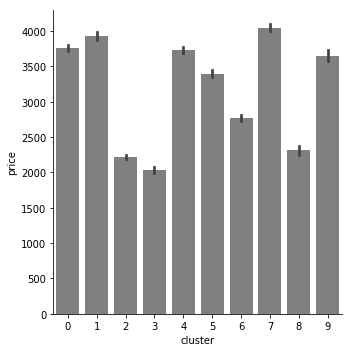

In [360]:
sns.catplot(x='cluster', y='price', data=train, kind = 'bar', color='grey')

#### Graph All Columns/Features

In [0]:
# Graph each column against target
#for col in sorted(train.columns):
#    if train[col].nunique() < 12:
#        sns.catplot(x=col, y='price', data = train, kind = 'bar', color = 'grey')
#        plt.show()

In [0]:
# Graph all numeric features
#numeric = train.select_dtypes('number')
#for col in sorted(numeric.columns):
#    sns.lmplot(x=col, y = 'price', data = train, scatter_kws = dict(alpha=0.05))
#    plt.show()

#### Engineer New Features

In [363]:
def engineer_features(df):
    #What's the neighborhood, based on address or latitude and longitude?
    clusters = pd.get_dummies(df['cluster'], prefix = 'cluster')
    for col in clusters:
        df[col] = clusters[col]

    #Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    #How long is the description?
    df['description_length'] = df['description'].str.len()

    #Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    #Are cats AND dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    #Total number of rooms
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

((31844, 50), (16973, 50))

#### Quick Test With Just Numeric Coulmns/Features No Nulls

In [364]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 41), (31844,), (16973, 41), (16973,))

#### Select the 10 Features That Best Correlate to Target Using SelectKBest

In [365]:
#Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest

#This is similar to the way we did linear regression last time
#model = LinearRegression()
#model.fit(...)
selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
elevator
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
rooms


#### Run Multiple Linear Regression with MAE, R^2, R^2 Adj.

In [366]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print('R^2 = ', result.rsquared)
print('R^2 Adj. = ', result.rsquared_adj)

Test MAE: $712
R^2 =  0.6032124054152115
R^2 Adj. =  0.6031002269785946


#### Run Again - Iterate and Add Features

In [0]:
for k in range(1, len(X_train.columns)+1):
  #print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  #print(f'Test MAE: ${mae:,.0f} ]\n')

### Logistic Regression

In [368]:
os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
    
# Install required python packages
!pip install -r requirements.txt
    
# Change into directory for module
os.chdir('module4')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.linear_model import LogisticRegressionCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [0]:
train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

#### Baseline

In [371]:
# Guess the majority class - functional and you are correct 54% of the time
y_train = train_labels['status_group']
y_train.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [372]:
# Use the first value which happens to be the majority class
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(len(y_pred))

59400


In [373]:
# Accuracy of majority class baseline = frequency of the majority class

accuracy_score(y_train, y_pred)

0.543080808080808

#### Train/Validate/Test Split

In [374]:
X_train = train_features
y_train = train_labels['status_group']

print(X_train.shape, y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, train_size = 0.80, test_size = 0.20,
  stratify = y_train, random_state=42
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, '\n')

print('Train Value Count:')
print(y_train.value_counts(normalize=True), '\n')
print('Validate Value Count:')
print(y_val.value_counts(normalize=True))

(59400, 40) (59400,)
(47520, 40) (11880, 40) (47520,) (11880,) 

Train Value Count:
functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64 

Validate Value Count:
functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64


#### Quick Test of Numeric Non-Null Features

In [375]:
# Drop non-numeric features
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

# Look for nulls, drop if found
X_train_numeric.isnull().sum()

# 1. Instantiate LoogisticRegressionCV
model = LogisticRegressionCV(n_jobs = -1)

# 2. Fit it
model.fit(X_train_numeric, y_train)

# 3. Evaluate accuracy score
model.score(X_val_numeric, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



0.5542087542087543

#### One-Hot Encoding - Examples

In [376]:
# Check values of quantity feature
X_train['quantity'].value_counts(normalize=True)

enough          0.559070
insufficient    0.255745
dry             0.103556
seasonal        0.068266
unknown         0.013363
Name: quantity, dtype: float64

In [377]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train

train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.967689
              functional                 0.026011
              functional needs repair    0.006300
enough        functional                 0.650920
              non functional             0.276998
              functional needs repair    0.072082
insufficient  functional                 0.521106
              non functional             0.382786
              functional needs repair    0.096108
seasonal      functional                 0.580456
              non functional             0.318434
              functional needs repair    0.101110
unknown       non functional             0.713386
              functional                 0.267717
              functional needs repair    0.018898
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quantity')

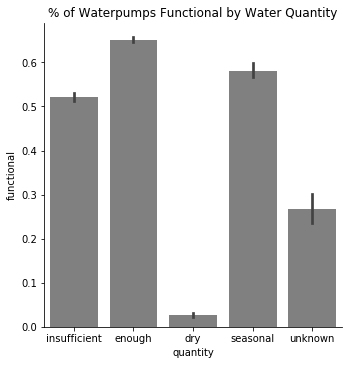

In [378]:
# Plot the values, dry shows a strong relationship to functional


train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='quantity', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quantity')

Text(0.5, 1.0, '% of Waterpumps Functional by Waterpoint Type')

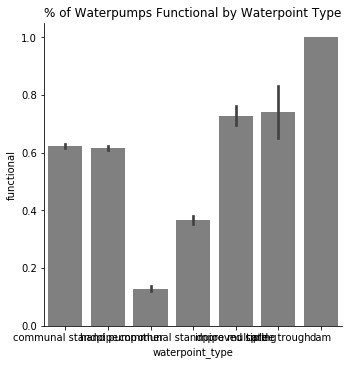

In [379]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train
train.groupby('waterpoint_type')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='waterpoint_type', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Waterpoint Type')

In [380]:
# Import package and scaler

# use quantity feature and the numerical ffeatures but drop id
categorical_features = ['quantity']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

# make subsets using the quantity feature all numeric features except id
X_train_subset = X_train[features]
X_val_subset = X_val[features]

# Do the encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

# Use the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Fit the model and check the accuracy
model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Validation Accuracy 0.6585016835016835


In [381]:
model.coef_

array([[ 1.34072363e-01,  4.10951619e-01, -9.47084405e-01,
         1.40772178e-01, -8.24851579e-02,  3.53781263e-01,
         2.15674988e-01,  4.48213423e-04, -1.30243712e-01,
         2.95020953e-03, -2.52559298e-01,  1.10785996e-01,
         2.61979488e-02, -1.27220926e-01],
       [ 4.58527547e-02,  6.66605840e-04, -8.08056088e-02,
         2.73808754e-02, -2.28254790e-02, -2.64965320e-03,
        -9.57584988e-03, -9.86022379e-02,  2.84648022e-02,
        -3.34295544e-03,  1.19487147e-02, -1.70460881e-02,
         1.59968060e-03, -2.36011014e-02],
       [-1.64130501e-01, -4.11475105e-01,  1.00385326e+00,
        -1.69002588e-01,  1.10326674e-01, -4.70101009e-01,
        -2.29590761e-01,  1.68839949e-01,  1.64522504e-01,
        -1.01437135e-03,  2.25715395e-01, -8.91399128e-02,
        -2.96384544e-02,  1.30939581e-01]])

In [382]:
functional_coefficients = pd.Series(
  model.coef_[0],
  X_train_encoded.columns
)

plt.figure(figsize=(10, 10))
functional_coefficients.sort_values().plot.bar

<bound method SeriesPlotMethods.bar of <pandas.plotting._core.SeriesPlotMethods object at 0x7f89fca8b4a8>>

<Figure size 720x720 with 0 Axes>